In [1]:
import numpy as np
import pandas as pd
import scipy
import itertools
import time
import sys
import datetime
import os
import validation_functions as vf

from kesi._verbose import (VerboseFFR,
                           LinearMixture,
                           LoadableVerboseFFR)
from kesi._engine import _LinearKernelSolver
sys.path.append('..')
from FEM.fem_sphere_gaussian import (SomeSphereGaussianSourceFactory3D,
                                     SomeSphereGaussianSourceFactoryOnlyCSD)
from _common_new import altitude_azimuth_mesh
import plotting_functions as pf
try:
    from joblib import Parallel, delayed
    import multiprocessing
    NUM_CORES = multiprocessing.cpu_count() - 1
    PARALLEL_AVAILABLE = True
except ImportError:
    PARALLEL_AVAILABLE = False

MeasurementManagerBase = VerboseFFR.MeasurementManagerBase

Unable to import from dolfin


In [2]:
def makemydir(directory):
    """
    Creates directory if it doesn't exist
    """
    try:
        os.makedirs(directory)
    except OSError:
        pass
    os.chdir(directory)

In [3]:
def generate_EEG_electrodesRPI(nr_theta, nr_phi, r):
    '''Determine positions of electrodes - EEG
    '''
    theta, phi, r = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, nr_theta),
                                np.linspace(0, 2*np.pi, nr_phi),
                                r)
    ELE_X = -r*np.cos(theta)*np.cos(phi)
    ELE_Y = r*np.cos(theta)*np.sin(phi)
    ELE_Z = r*np.sin(theta)
    ELECTRODES = pd.DataFrame({'X': ELE_X.flatten(),
                               'Y': ELE_Y.flatten(),
                               'Z': ELE_Z.flatten()})
    ELECTRODES_NR = ELE_X.size
    return ELECTRODES, ELECTRODES_NR

def generate_ECoG_electrodes(nr_x, nr_y, Z):
    '''Determine positions of electrodes - ECoG
    '''
    xx, yy, zz = np.meshgrid(np.linspace(-0.035, 0.035, nr_x),
                             np.linspace(-0.035, 0.035, nr_y),
                             [-Z])
    ELE_PLANE = np.zeros([xx.size, 3])
    ELE_PLANE[:, 0] = xx.flatten()
    ELE_PLANE[:, 1] = yy.flatten()
    ELE_PLANE[:, 2] = zz.flatten()
    ELE_SPHERE = np.array([Z*ELE_PLANE[i]/np.linalg.norm(ELE_PLANE[i]) for i in range(xx.size)])
    ELECTRODES = pd.DataFrame({'X': ELE_SPHERE[:, 0],
                               'Y': ELE_SPHERE[:, 1],
                               'Z': ELE_SPHERE[:, 2]})
    ELECTRODES_NR = xx.size
    return ELECTRODES, ELECTRODES_NR

In [4]:
start_time = time.time()
meshname = 'four_spheres_gaussian_1000_deg_1'
MESHFILE = '/home/mbejtka/Data_Kuba/' + meshname + '.npz'
now = datetime.datetime.today() 
nTime = now.strftime('%Y-%m-%d_%H-%M-%S')
save_path = sys.path[0] + '/results/' + nTime
makemydir(save_path)
forward_model = 'four_spheres'

factory = SomeSphereGaussianSourceFactory3D(MESHFILE)
print("Loading data --- %s seconds ---" % (time.time() - start_time))

dst = factory.R[1] - factory.R[0]
sources = [factory(r, altitude, azimuth)
           for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
           for r in factory.R]
setup_dict = {'meshname': meshname, 'path': save_path, 'sources': sources}
print('Number of sources: ', len(sources))
print("Sources --- %s seconds ---" % (time.time() - start_time))

Loading data --- 2.560640573501587 seconds ---
Number of sources:  45508
Sources --- 6.675027847290039 seconds ---


In [14]:
coord = open('/home/mbejtka/Marta/Epilepsy data/'
             '20140904 data from Ania Korzeniewska/NW_later_176/'
             'coordinates_NW_later.txt', 'r')

ele_location = coord.readlines()
coord.close()
coordinates = np.zeros([len(ele_location), 3])
for i in range(len(ele_location)):
    crd = ele_location[i].split('\t')
    coordinates[i, :] = crd[0:3]
    for j in range(3):
        coordinates[i, j] = float(coordinates[i, j]/1000)
    coordinates[i] = list(coordinates[i])

In [13]:
factory.scalp_radius

array(0.09)

In [6]:
R = 0.9
ELE_SPHERE = np.array([R*coordinates[i]/np.linalg.norm(coordinates[i]) for i in range(coordinates.shape[0])])

In [15]:
x = np.max(coordinates[:, 0]) - factory.R.max()
y = np.max(coordinates[:, 1]) - factory.R.max()
z = np.max(coordinates[:, 2]) - factory.R.max()
coordinates2 = np.array([[coordinates[i, 0] - x, coordinates[i, 1] - y, coordinates[i, 2] - z] for i in range(coordinates.shape[0])])

In [16]:
coordinates2

array([[ 0.070374 ,  0.044539 ,  0.0074626],
       [ 0.073399 ,  0.045288 ,  0.0149529],
       [ 0.075522 ,  0.045196 ,  0.0246501],
       [ 0.07724  ,  0.04473  ,  0.034929 ],
       [ 0.0775   ,  0.042741 ,  0.044922 ],
       [ 0.076226 ,  0.039934 ,  0.054739 ],
       [ 0.073207 ,  0.035754 ,  0.064033 ],
       [ 0.068874 ,  0.030407 ,  0.071767 ],
       [ 0.064814 ,  0.05305  ,  0.006973 ],
       [ 0.067974 ,  0.053514 ,  0.0160988],
       [ 0.069707 ,  0.053176 ,  0.026279 ],
       [ 0.070976 ,  0.052031 ,  0.036547 ],
       [ 0.071328 ,  0.050367 ,  0.0467   ],
       [ 0.069987 ,  0.047678 ,  0.056409 ],
       [ 0.067267 ,  0.04337  ,  0.065484 ],
       [ 0.063343 ,  0.038497 ,  0.073443 ],
       [ 0.059207 ,  0.06123  ,  0.0078106],
       [ 0.061627 ,  0.061291 ,  0.0173133],
       [ 0.06329  ,  0.060485 ,  0.027462 ],
       [ 0.064147 ,  0.05932  ,  0.037801 ],
       [ 0.064374 ,  0.057668 ,  0.048134 ],
       [ 0.063226 ,  0.054872 ,  0.058346 ],
       [ 0

In [64]:
ELECTRODES_ALL, ELECTRODES_NR_ALL = generate_EEG_electrodesRPI(15,
                                                           15,
                                                           factory.R.max())

In [48]:
center = [0.08240997559, 0.11814496578, 0.10473314426]
radius = [0.07321604532]

In [49]:
vector = [-1*center[0], -1*center[1], -1*center[2]]

In [50]:
vector

[-0.08240997559, -0.11814496578, -0.10473314426]

In [59]:
coordinates2 = np.array([coordinates[i] + vector for i in range(coordinates.shape[0])])

In [60]:
coordinates2.shape

(82, 3)

In [66]:
coordinates.shape
#ELE_X = ELE_SPHERE[:, 0]
#ELE_Y = ELE_SPHERE[:, 1]
#ELE_Z = ELE_SPHERE[:, 2]
ELE_X = coordinates2[:, 0]
ELE_Y = coordinates2[:, 1]
ELE_Z = coordinates2[:, 2]
ELECTRODES = pd.DataFrame({'X': ELE_X,
                           'Y': ELE_Y,
                           'Z': ELE_Z})

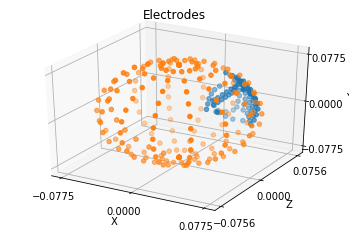

In [67]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(ELE_X, ELE_Y, ELE_Z)
ax.scatter(ELECTRODES_ALL.X, ELECTRODES_ALL.Y, ELECTRODES_ALL.Z)
ax.set_title('Electrodes')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xticks([ELECTRODES_ALL.X.min(), 0, ELECTRODES_ALL.X.max()])
ax.set_yticks([ELECTRODES_ALL.Y.min(), 0, ELECTRODES_ALL.Y.max()])
ax.set_zticks([ELECTRODES_ALL.Z.min(), 0, ELECTRODES_ALL.Z.max()])
plt.savefig(save_path + '/Combined_electrodes.png', dpi=300)

In [ ]:
ele_type = 'ECoG'

if ele_type == 'EEG':
    ELECTRODES, ELECTRODES_NR = generate_EEG_electrodesRPI(15,
                                                           15,
                                                           [factory.scalp_radius])
elif ele_type == 'ECoG':
    ELECTRODES, ELECTRODES_NR = generate_ECoG_electrodes(8, 8, factory.R.max())
elif ele_type == 'Korzeniewska':
    
setup_dict.update({'ele_type': ele_type, 'ELECTRODES': ELECTRODES})

In [68]:
# Estimating points    
r = factory.scalp_radius
X, Y, Z = np.meshgrid(np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30))
IDX = X**2 + Y**2 + Z**2 <=r**2
EST_X = X[IDX]
EST_Y = Y[IDX]
EST_Z = Z[IDX]
EST_POINTS =pd.DataFrame({'X': EST_X.flatten(),
                          'Y': EST_Y.flatten(),
                          'Z': EST_Z.flatten()})
setup_dict.update({'X':X, 'Y':Y, 'Z':Z, 'IDX': IDX, 'EST_POINTS': EST_POINTS})

In [69]:
measurement_manager = vf.MeasurementManager(ELECTRODES, space='potential')
measurement_manager_basis = vf.MeasurementManager(EST_POINTS, space='csd')

In [70]:
# Create reconstructor
reconstructor_filename = save_path +'/Reconstructor.npz'
reconstructor = VerboseFFR(sources, measurement_manager)
reconstructor.save(reconstructor_filename)
print("Reconstructor --- %s seconds ---" % (time.time() - start_time))

Reconstructor --- 4817.337017059326 seconds ---


In [71]:
factoryCSD = SomeSphereGaussianSourceFactoryOnlyCSD(MESHFILE)
dst = factoryCSD.R[1] - factoryCSD.R[0]
sourcesCSD = [factoryCSD(r, altitude, azimuth)
              for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
              for r in factoryCSD.R]

In [72]:
loadable_reconstructor = LoadableVerboseFFR(reconstructor_filename, sourcesCSD, measurement_manager)
kernel = loadable_reconstructor.kernel
cross_kernel = loadable_reconstructor.get_kernel_matrix(measurement_manager_basis)
cross_reconstructor = loadable_reconstructor._CrossKernelReconstructor(_LinearKernelSolver(kernel), cross_kernel)

In [73]:
cross_reconstructor_filename = save_path + '/CrossReconstructor.npz'
cross_reconstructor.save(cross_reconstructor_filename)

In [74]:
potential = [measurement_manager.probe(source) for source in sources]

In [75]:
true_csd = [measurement_manager_basis.probe(source) for source in sourcesCSD]

In [76]:
setup_dict.update({'POTENTIAL': potential, 'TRUE_CSD': true_csd})
np.savez_compressed(save_path + '/Setup_info.npz', **setup_dict)

In [77]:
eigensources, eigenvalues, eigenvectors = vf.calculate_eigensources(kernel, cross_kernel, regularization_parameter=0)
projection = vf.csd_into_eigensource_projection(true_csd, eigensources)
np.savez_compressed(save_path + '/Spectral_decomposition.npz',
                    EIGENSOURCES=eigensources,
                    EIGENVALUES=eigenvalues, EIGENVECTORS=eigenvectors,
                    PROJECTION=projection)

In [78]:
eigen_parameters = eigenvalues[np.where(eigenvalues > 0)]

In [ ]:
#l_lambd, lcurve_axis, curve_surf, lambdas = [L_curve(kernel, potential[src_nr], lambdas=np.logspace(-20, -1, 30))
#                                             for src_nr in range(len(sources))]

In [113]:
import plotting_functions as pf
%load_ext autoreload
%autoreload 2

In [153]:
from imp import reload 
reload(pf)
reload(vf)

<module 'validation_functions' from '/home/mbejtka/FEM/kESI/extras/validation/validation_functions.py'>

In [121]:
src_nr = 20090
potential_noise, noise = vf.add_noise(potential[src_nr], seed=0, level=30)
l_lambd, lcurve_axis, curve_surf, lambdas = vf.L_curve(kernel, potential_noise, lambdas=eigen_parameters)

[1.58434981e-04 2.19022025e-04 2.26038736e-04 2.36061065e-04
 2.43252634e-04 2.54965357e-04 2.63337304e-04 2.87716244e-04
 2.87983183e-04 3.01625477e-04 3.19393932e-04 3.28566390e-04
 3.42126399e-04 3.45185511e-04 3.60361803e-04 3.86232308e-04
 4.08173517e-04 4.49166899e-04 5.24818365e-04 5.45324748e-04
 5.84066962e-04 6.68392872e-04 6.93189633e-04 7.40041057e-04
 7.71184868e-04 8.77526531e-04 9.14522002e-04 9.45346084e-04
 1.11072498e-03 1.23320472e-03 1.33818059e-03 1.44214756e-03
 1.61852250e-03 1.84792813e-03 2.05292692e-03 2.14328626e-03
 2.41773770e-03 2.75547320e-03 3.09623915e-03 3.54730302e-03
 4.02784237e-03 4.30536636e-03 4.47263927e-03 4.75897343e-03
 5.20949869e-03 6.45881315e-03 6.81064842e-03 8.21487187e-03
 9.09632750e-03 1.10352466e-02 1.29643254e-02 1.51421181e-02
 1.63733448e-02 1.86065286e-02 2.65203278e-02 3.08865823e-02
 3.66090407e-02 4.98976558e-02 6.71633797e-02 7.31006095e-02
 9.54013920e-02 9.89147503e-02 1.58678876e-01 1.67812499e-01
 2.42812101e-01 2.772714

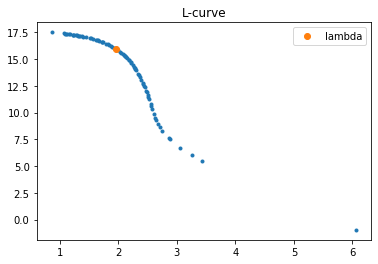

In [122]:
plt.figure()
plt.plot(lcurve_axis[1], lcurve_axis[0], '.')
plt.plot(lcurve_axis[1, np.where(lambdas==l_lambd)], lcurve_axis[0, np.where(lambdas==l_lambd)], 'o', label='lambda')
plt.title('L-curve')
plt.legend()
plt.savefig(save_path + '/L-curve.png')

In [123]:
reg_params = np.logspace(-20, 1, 30)
EST_CSD_0, indx_rp0, EE_0, rp0 = vf.estimate_csd(cross_reconstructor, potential_noise.reshape(1,len(potential[src_nr])),
                                        regularization_parameters=reg_params)

Cross validating regularization parameter : 1e-20
Cross validating regularization parameter : 5.2983169062837234e-20
Cross validating regularization parameter : 2.80721620394117e-19
Cross validating regularization parameter : 1.4873521072935118e-18
Cross validating regularization parameter : 7.880462815669937e-18
Cross validating regularization parameter : 4.175318936560392e-17
Cross validating regularization parameter : 2.2122162910704503e-16
Cross validating regularization parameter : 1.1721022975334793e-15
Cross validating regularization parameter : 6.210169418915603e-15
Cross validating regularization parameter : 3.290344562312671e-14
Cross validating regularization parameter : 1.7433288221999874e-13
Cross validating regularization parameter : 9.236708571873846e-13
Cross validating regularization parameter : 4.893900918477499e-12
Cross validating regularization parameter : 2.5929437974046672e-11
Cross validating regularization parameter : 1.373823795883261e-10
Cross validating regu

In [124]:
reg_params[indx_rp0]

array([1.88739182])

In [125]:
est_csd_noise = cross_reconstructor(potential_noise, reg_params[indx_rp0])

In [126]:
est_csd_noise_0 = cross_reconstructor(potential_noise, np.array([0]))

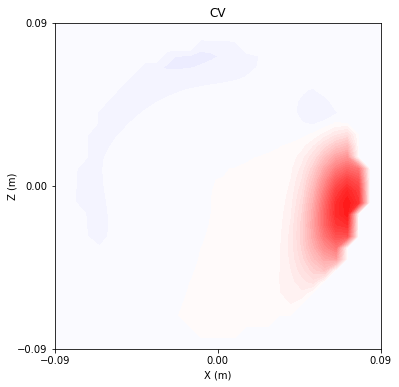

In [127]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
t_max = np.max(abs(est_csd_noise))
pf.make_subplot(ax, pf.values_in_a_grid(X, est_csd_noise, IDX), 'csd', X, Y, Z, t_max, idx=15, fig_title='CV')

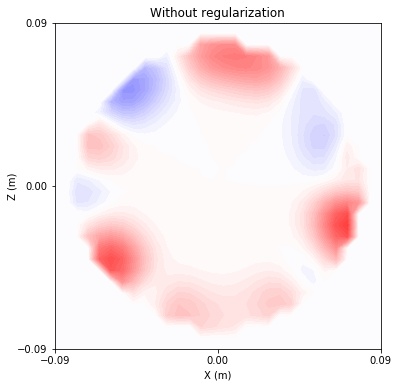

In [128]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
t_max = np.max(abs(est_csd_noise_0))
pf.make_subplot(ax, pf.values_in_a_grid(X, est_csd_noise_0, IDX), 'csd', X, Y, Z, t_max, idx=15, fig_title='Without regularization')

In [129]:
est_csd_noise_lc = cross_reconstructor(potential_noise, l_lambd)

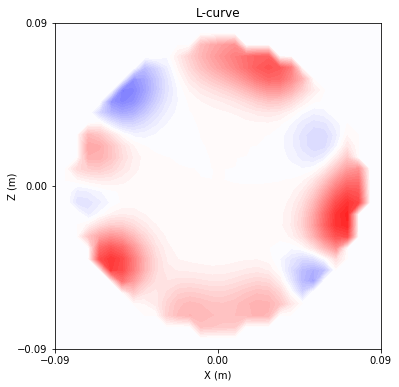

In [130]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
t_max = np.max(abs(est_csd_noise_lc))
pf.make_subplot(ax, pf.values_in_a_grid(X, est_csd_noise_lc, IDX), 'csd', X, Y, Z, t_max, idx=15, fig_title='L-curve')

In [131]:
EST_CSD_LC, indx_rpLC, EE_LC, rpLC = vf.estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=np.array([l_lambd]))

Cross validating regularization parameter : 0.0020529269199011193


In [132]:
EST_CSD_0, indx_rp0, EE_0, rp0 = vf.estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=np.array([0]))

Cross validating regularization parameter : 0


In [133]:
regularization_parameters = eigen_parameters
EST_CSD, indx_rp, EE, rp = vf.estimate_csd(cross_reconstructor, potential,
                                        regularization_parameters=regularization_parameters)

Cross validating regularization parameter : 615661.9341739861
Cross validating regularization parameter : 317.26286263774074
Cross validating regularization parameter : 154.84735637465374
Cross validating regularization parameter : 62.659986069534206
Cross validating regularization parameter : 24.77437355854129
Cross validating regularization parameter : 20.394178532510832
Cross validating regularization parameter : 9.322358252635858
Cross validating regularization parameter : 6.28840686816303
Cross validating regularization parameter : 4.666613706294565
Cross validating regularization parameter : 2.937896999642412
Cross validating regularization parameter : 2.393345525054936
Cross validating regularization parameter : 1.66377535935064
Cross validating regularization parameter : 0.9598388092067383
Cross validating regularization parameter : 0.7078809360172968
Cross validating regularization parameter : 0.5716334305233174
Cross validating regularization parameter : 0.33961125423988575
C

In [88]:
indx_rp.shape

(45508,)

In [135]:
indx_rp2[0]

10

In [136]:
src_nr = 20090
EST_CSD2, indx_rp2, EE2, rp2 = vf.estimate_csd(cross_reconstructor, potential_noise.reshape(1,len(potential[src_nr])),
                                        regularization_parameters=eigen_parameters)

Cross validating regularization parameter : 615661.9341739861
Cross validating regularization parameter : 317.26286263774074
Cross validating regularization parameter : 154.84735637465374
Cross validating regularization parameter : 62.659986069534206
Cross validating regularization parameter : 24.77437355854129
Cross validating regularization parameter : 20.394178532510832
Cross validating regularization parameter : 9.322358252635858
Cross validating regularization parameter : 6.28840686816303
Cross validating regularization parameter : 4.666613706294565
Cross validating regularization parameter : 2.937896999642412
Cross validating regularization parameter : 2.393345525054936
Cross validating regularization parameter : 1.66377535935064
Cross validating regularization parameter : 0.9598388092067383
Cross validating regularization parameter : 0.7078809360172968
Cross validating regularization parameter : 0.5716334305233174
Cross validating regularization parameter : 0.33961125423988575
C

In [137]:
np.logspace(-5, 5, 100)[indx_rp2]

array([0.00016298])

In [ ]:
plt.figure()
plt.plot(np.logspace(-5, 5, 100), EE2, '.', label='regular')
plt.plot(eigen_parameters, EEn, '.', label='eigenV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Regularization parameter')
plt.ylabel('Error in potential space')
plt.legend()
plt.savefig(save_path + '/Pots_Error_eigenvalues_vs_regular_params.png')

In [139]:
regularization_parameters = eigen_parameters
EST_CSDn, indx_rpn, EEn, rpn = vf.estimate_csd(cross_reconstructor, noise.reshape(1,len(potential[src_nr])),
                                        regularization_parameters=regularization_parameters)

Cross validating regularization parameter : 615661.9341739861
Cross validating regularization parameter : 317.26286263774074
Cross validating regularization parameter : 154.84735637465374
Cross validating regularization parameter : 62.659986069534206
Cross validating regularization parameter : 24.77437355854129
Cross validating regularization parameter : 20.394178532510832
Cross validating regularization parameter : 9.322358252635858
Cross validating regularization parameter : 6.28840686816303
Cross validating regularization parameter : 4.666613706294565
Cross validating regularization parameter : 2.937896999642412
Cross validating regularization parameter : 2.393345525054936
Cross validating regularization parameter : 1.66377535935064
Cross validating regularization parameter : 0.9598388092067383
Cross validating regularization parameter : 0.7078809360172968
Cross validating regularization parameter : 0.5716334305233174
Cross validating regularization parameter : 0.33961125423988575
C

In [140]:
rpn

0.0001584349805809308

In [93]:
np.savez_compressed(save_path + '/Estimation.npz', EST_CSD_CV=EST_CSD, indx_rp=indx_rp, EE=EE,
                    LAMBD=rp, REG_PARAMS=regularization_parameters, L_LAMBD=l_lambd, LCURVE=lcurve_axis,
                    EST_CSD_0=EST_CSD_0, EE_0=EE_0, EST_CSD_LC=EST_CSD_LC, EE_LC=EE_LC)

NameError: name 'l_lambd' is not defined

In [141]:
src_nr = 20090
rms = np.zeros(len(eigen_parameters))
rdm = np.zeros(len(eigen_parameters))
mag = np.zeros(len(eigen_parameters))
for j, value in enumerate(eigen_parameters):
    est_csd_ev = cross_reconstructor(potential[src_nr], np.array(value))
    rms[j] = vf.calculate_rms(true_csd[src_nr], est_csd_ev)
    rdm[j] = vf.calculate_rdm(true_csd[src_nr], est_csd_ev)
    mag[j] = vf.calculate_mag(true_csd[src_nr], est_csd_ev)
np.savez_compressed(save_path + '/GlobalErrorsSrcNr' + str(src_nr) + '.npz', RMS=rms, RDM=rdm, MAG=mag)

In [142]:
src_nr = 20090
#eigen_parameters2 = np.logspace(-5, 5, 64)
eigen_parameters2 = eigen_parameters
rms_n = np.zeros(len(eigen_parameters2))
rdm_n = np.zeros(len(eigen_parameters2))
mag_n = np.zeros(len(eigen_parameters2))
for j, value in enumerate(eigen_parameters2):
    est_csd_ev = cross_reconstructor(potential_noise, np.array(value))
    rms_n[j] = vf.calculate_rms(true_csd[src_nr], est_csd_ev)
    rdm_n[j] = vf.calculate_rdm(true_csd[src_nr], est_csd_ev)
    mag_n[j] = vf.calculate_mag(true_csd[src_nr], est_csd_ev)
np.savez_compressed(save_path + '/GlobalErrorsNoiseSrcNr' + str(src_nr) + '.npz', RMS=rms_n, RDM=rdm_n, MAG=mag_n)

In [143]:
src_nr = 20090
#eigen_parameters2 = np.logspace(-5, 5, 64)
eigen_parameters2 = eigen_parameters
rms_noise = np.zeros(len(eigen_parameters2))
rdm_noise = np.zeros(len(eigen_parameters2))
mag_noise = np.zeros(len(eigen_parameters2))
for j, value in enumerate(eigen_parameters2):
    est_csd_ev = cross_reconstructor(noise, np.array(value))
    rms_noise[j] = vf.calculate_rms(true_csd[src_nr], est_csd_ev)
    rdm_noise[j] = vf.calculate_rdm(true_csd[src_nr], est_csd_ev)
    mag_noise[j] = vf.calculate_mag(true_csd[src_nr], est_csd_ev)

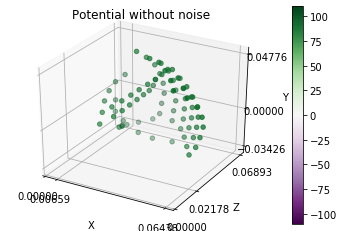

In [144]:
pf.plot_potential_ele(ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z, potential[src_nr], 'Potential without noise', save_path)

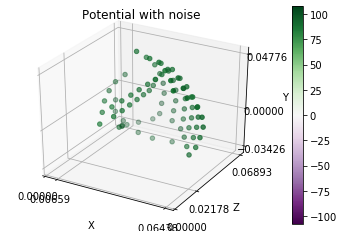

In [145]:
pf.plot_potential_ele(ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z, potential_noise, 'Potential with noise', save_path)

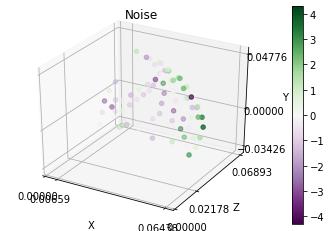

In [146]:
pf.plot_potential_ele(ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z, noise, 'Noise', save_path)

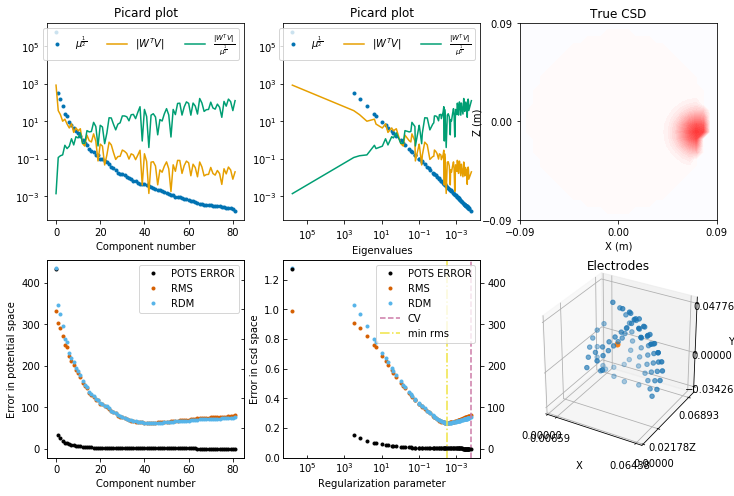

In [147]:
layer = 15
src_nr = 20090
pf.generate_Picard_subplot(eigenvalues, eigenvectors, true_csd[src_nr], potential[src_nr], EE[:, src_nr],
                           rms, rdm, mag, eigen_parameters[indx_rp[src_nr]], forward_model, src_nr, save_path,
                           ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z,
                           sources[src_nr].x, sources[src_nr].y, sources[src_nr].z, X, Y, Z, IDX, layer)

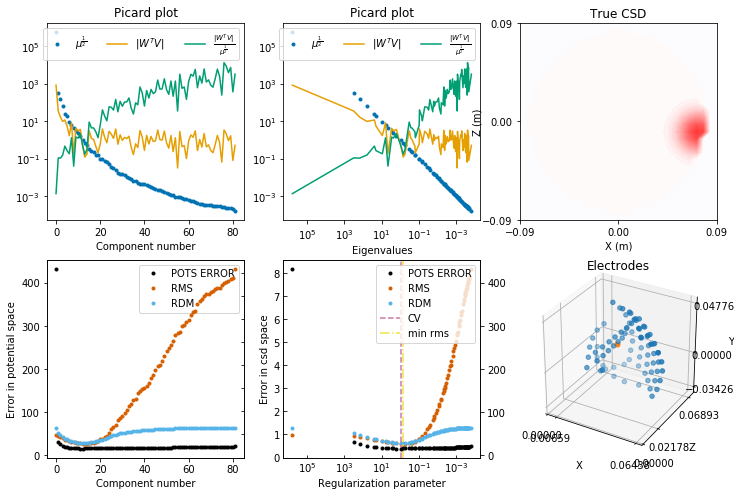

In [148]:
src_nr = 20090
pf.generate_Picard_subplot(eigenvalues, eigenvectors, true_csd[src_nr], potential_noise, EE2,
                           rms_n, rdm_n, mag_n, eigen_parameters[indx_rp2[0]], forward_model, src_nr, save_path,
                           ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z,
                           sources[src_nr].x, sources[src_nr].y, sources[src_nr].z, X, Y, Z, IDX, layer)

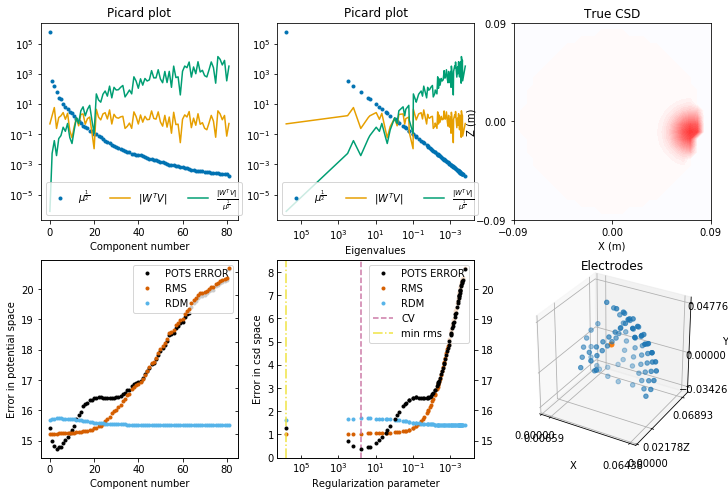

In [149]:
src_nr = 20090
pf.generate_Picard_subplot(eigenvalues, eigenvectors, true_csd[src_nr], noise, EEn,
                           rms_noise, rdm_noise, mag_noise, eigen_parameters[indx_rpn[0]], forward_model, src_nr, save_path,
                           ELECTRODES.X, ELECTRODES.Y, ELECTRODES.Z,
                           sources[src_nr].x, sources[src_nr].y, sources[src_nr].z, X, Y, Z, IDX, layer)

RealisticEle validation CVL-curve src_nr 20090


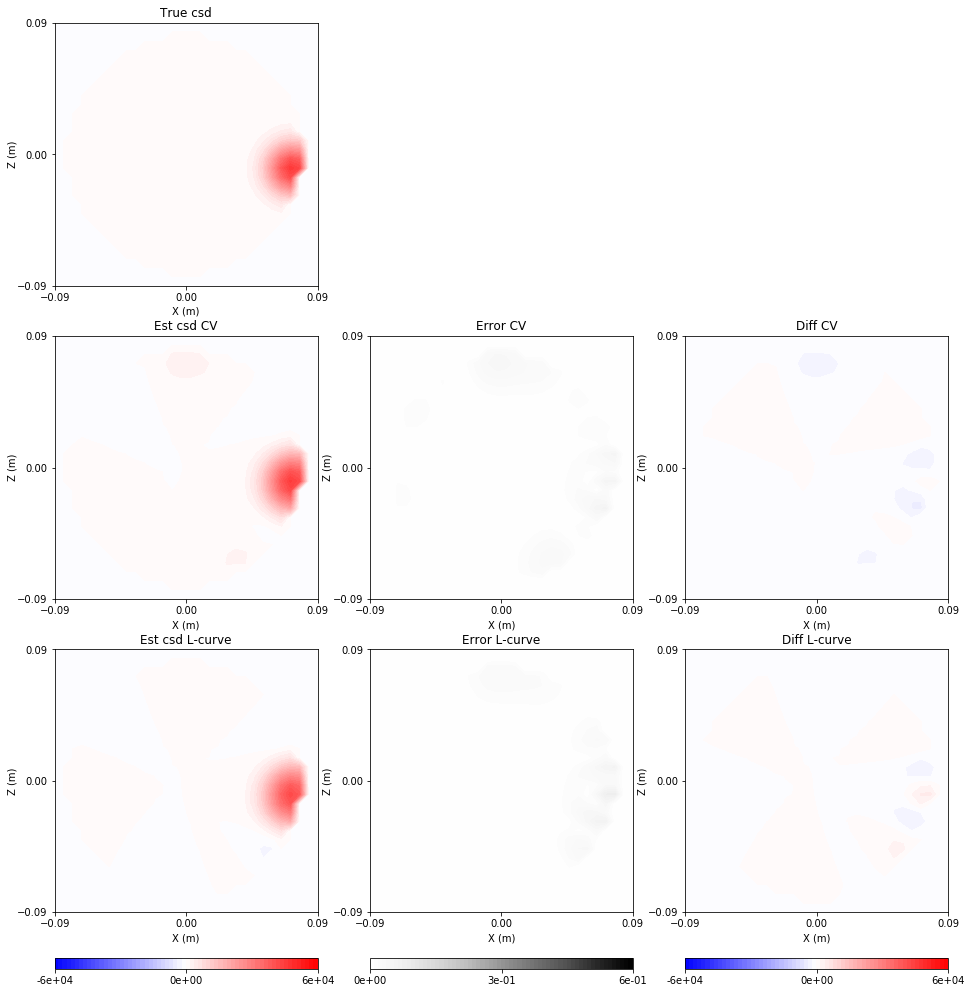

In [154]:
src_nr = 20090
layer = 15
sphere = 'RealisticEle'
pf.generate_subplot(X, Y, Z, true_csd, EST_CSD, 'CV', EST_CSD_LC, 'L-curve', IDX, layer, str(sphere), src_nr, save_path)

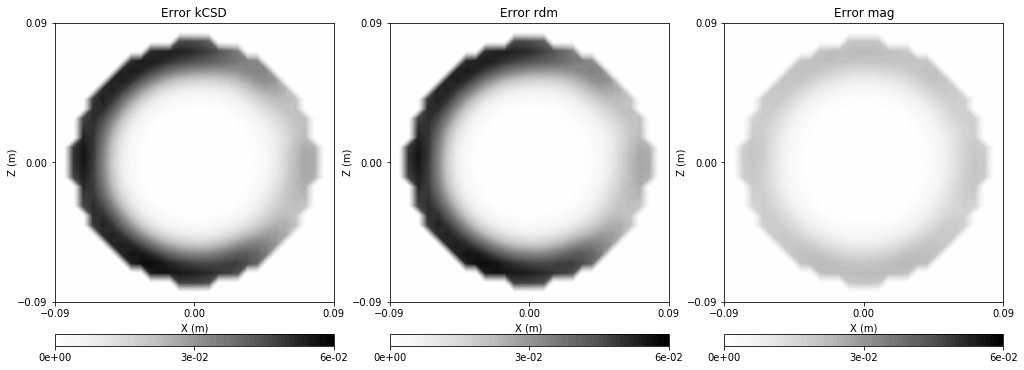

In [156]:
fig_title = str(sphere) + '_ReliabilityMaps_LC'
pf.generate_reliability_maps(X, Y, Z, true_csd, EST_CSD_LC, IDX, layer, fig_title, save_path)

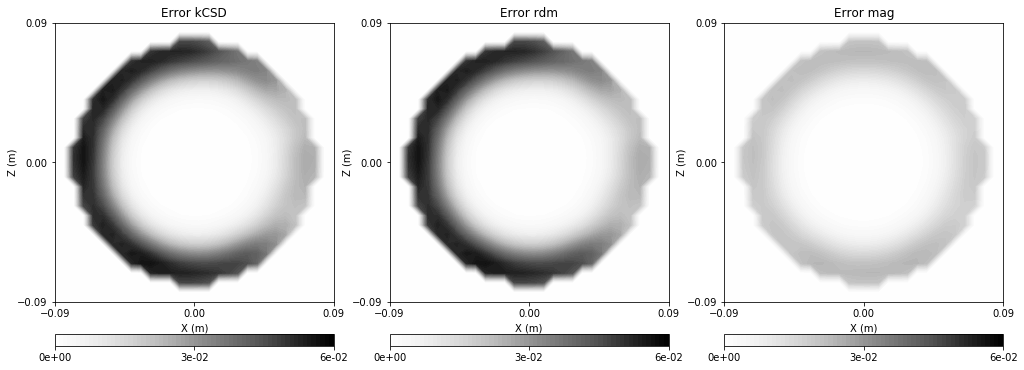

In [158]:
fig_title = str(sphere) + '_ReliabilityMaps_CV'
pf.generate_reliability_maps(X, Y, Z, true_csd, EST_CSD, IDX, layer, fig_title, save_path)

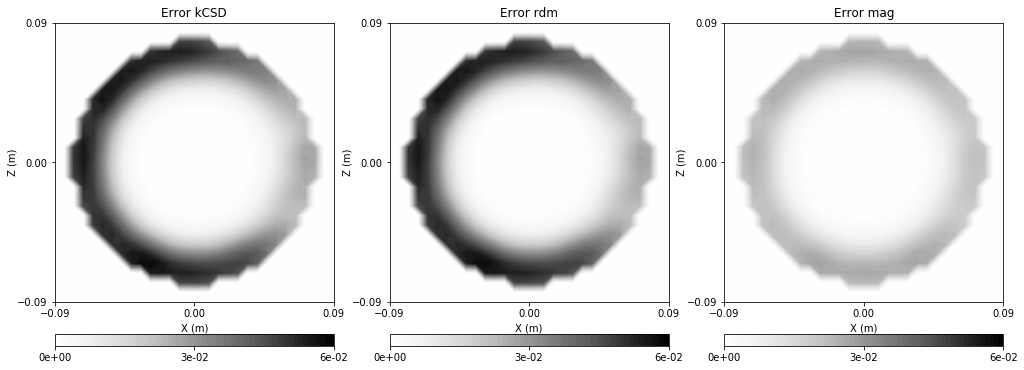

In [159]:
fig_title = str(sphere) + '_ReliabilityMaps_RP0'
pf.generate_reliability_maps(X, Y, Z, true_csd, EST_CSD_0, IDX, layer, fig_title, save_path)

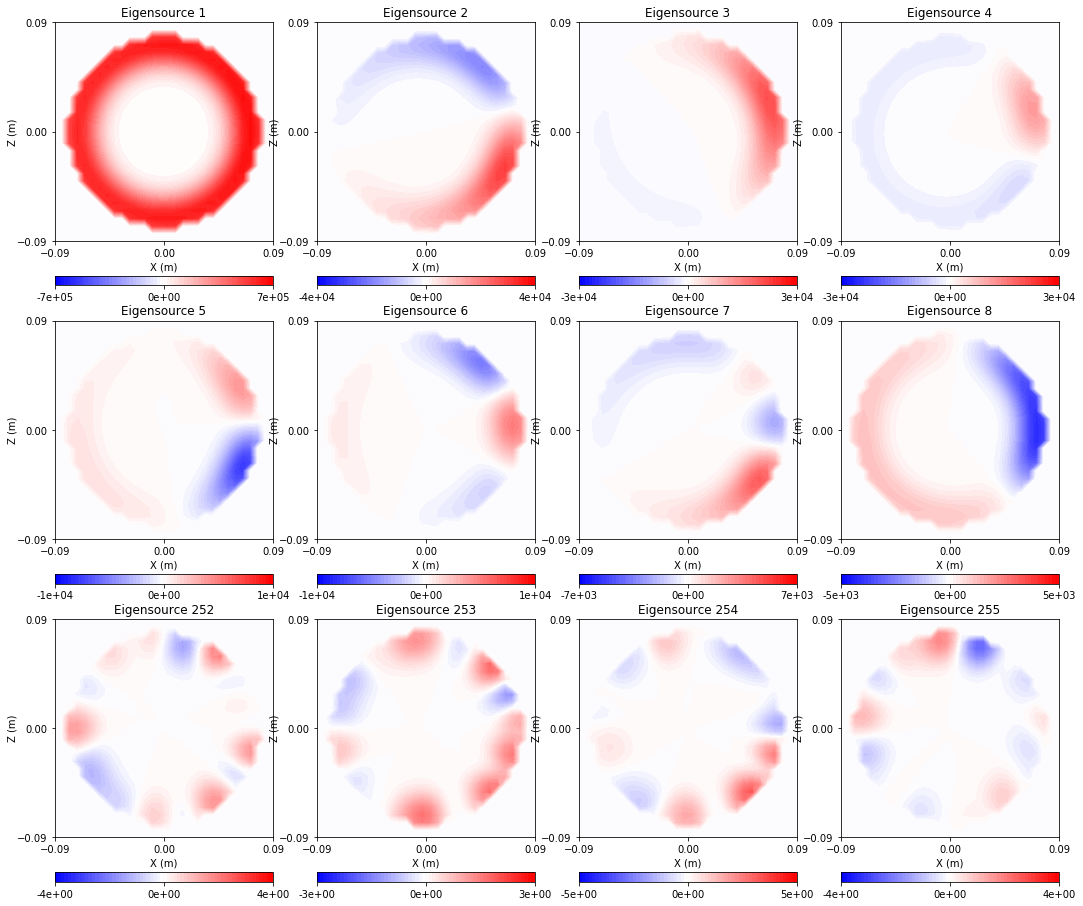

In [160]:
pf.generate_eigensource_subplot(X, Y, Z, eigensources, IDX, layer, str(sphere)+'_Eigensources_different_scales', save_path)

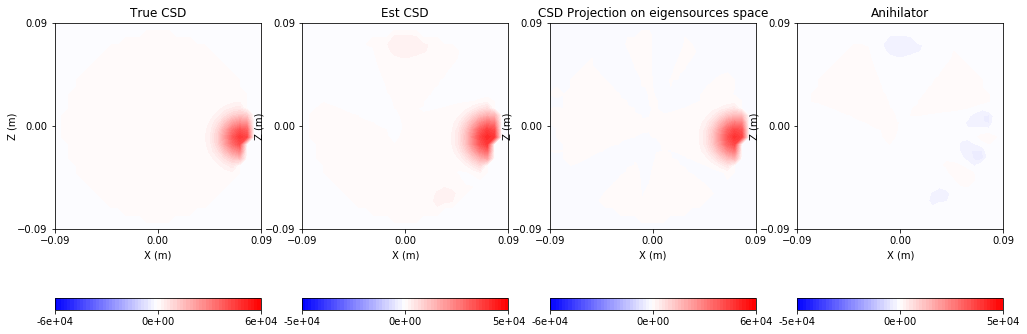

In [161]:
pf.generate_projection_subplot(X, Y, Z, true_csd[src_nr], EST_CSD[src_nr], eigensources, projection[src_nr], IDX, layer, str(sphere)+'_Projection', save_path)

In [162]:
#########
# Loading experimental data 

In [164]:
hdr_text = open('/home/mbejtka/Marta/Epilepsy data/'
                '20140904 data from Ania Korzeniewska/NW_later_176/'
                'datac.hdr', 'r')

text_list = hdr_text.readlines()
hdr_text.close()
text = []
for i in range(len(text_list)):
    text.append(text_list[i][0:-1])
for s in text:
    if "Numb_chans" in s:
        nr_channels = int(s[11:15])
        break

In [165]:
nr_channels

102

In [166]:
sig = np.fromfile('/home/mbejtka/Marta/Epilepsy data/'
                  '20140904 data from Ania Korzeniewska/NW_later_176/'
                  'datac0.en.000', dtype='float')

nr_records = 6
nr_samples = len(sig)
signal = np.zeros([nr_records, nr_channels, nr_samples])
for i in range(nr_records):
    for j in range(nr_channels):
        signal[i, j, :] = np.fromfile('/home/mbejtka/Marta/Epilepsy data/'
                                      '20140904 data from Ania Korzeniewska/'
                                      'NW_later_176/'
                                      'datac'+str(i)+'.en.' +
                                      "{0:0>3}".format(j), dtype='float')

In [167]:
signal.shape

(6, 102, 420000)

In [170]:
ele_pos = coordinates/1000
pots = signal[0, 0:ele_pos.shape[0], 0:2]

In [171]:
pots.shape

(82, 2)